In [1]:
import datetime
from time import process_time

import spacy
from random import sample
import stanza

from textblob import TextBlob
import textblob.sentiments as tb
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.collocations import *
from nltk.metrics import BigramAssocMeasures

import pandas as pd

from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

**Setup:**

In [2]:
sources = ['nytimes', 'CNN', 'bbcworld', 'theeconomist', 'reuters', 'WSJ', 'TIME', 'ABC', 'washingtonpost', 'AP']

In [3]:
#to get a string back to a datetime object
to_dt = lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

In [4]:
#style:
sns.set_style('darkgrid')

#context:
sns.set_context('notebook')

In [5]:
ORDER = ['nytimes', 'CNN', 'bbcworld', 'theeconomist', 'reuters', 'WSJ', 'TIME', 'ABC', 'washingtonpost', 'AP']
PAL = sns.husl_palette(10, l = 0.6, s = 0.6, h = 0.7)

**Trying things out:**

In [6]:
dt = pd.read_csv('DATA/ALL.csv', index_col = 'ID')
dt['Date_Time'] = dt['Date_Time'].apply(to_dt)
dt.head()

,User,Source_Name,Tweet_Text,Date_Time,Sentiment,Named_Entities
ID,,,,,,
1234991999750565888,nytimes,The New York Times,"Polls have now closed in Vermont, Virginia and...",2020-03-04 00:00:12,0.018,"[('Vermont', 1, 'GPE'), ('Virginia', 1, 'GPE')..."
1234993730874011649,nytimes,The New York Times,Breaking News: Joe Biden won Virginia and Bern...,2020-03-04 00:07:05,0.323,"[('Joe Biden', 1, 'PERSON'), ('Virginia', 1, '..."
1234996189403041795,nytimes,The New York Times,Our reporters are providing real-time updates ...,2020-03-04 00:16:51,0.417,"[('Super Tuesday', 1, 'DATE')]"
1234997580829872128,nytimes,The New York Times,As we wait for more polls to close in Super Tu...,2020-03-04 00:22:23,0.411,"[('Tuesday', 1, 'DATE'), ('Democratic', 1, 'NO..."
1234999525594423296,nytimes,The New York Times,Polls have now closed in North Carolina. Follo...,2020-03-04 00:30:06,0.123,"[('North Carolina', 1, 'GPE'), ('Tuesday', 1, ..."


In [7]:
dt['User'].value_counts()

reuters           12030
ABC                4649
CNN                4615
washingtonpost     4130
nytimes            3207
theeconomist       3179
WSJ                2633
TIME               2398
AP                 1764
bbcworld           1186
Name: User, dtype: int64

In [8]:
col = dt['Tweet_Text'].fillna('').str.lower()

sub = dt[col.str.contains('covid') | col.str.contains('coronavirus')]

In [9]:
sub['Tweet_Text'].values[ : : 100][ : 10]

array(['RT @ByMikeBaker: Coronavirus today: • 9 dead • Past deaths tied to virus • 2 people in their 20s hospitalized • 12 first responders ill • A…',
       'Days after a coronavirus outbreak emerged inside a nursing home in suburban Seattle, leaders at 2 other complexes that serve older residents in the region said that each of those facilities had a resident who had tested positive for the virus ',
       'While the coronavirus prompts shutdowns and economic alarm across the world, the Chinese province where the epidemic began announced that it would — ever so carefully — restart business and manufacturing ',
       "RT @nytopinion: Why have only\xa0about 5,000\xa0Americans been tested been tested for the coronavirus so far? It's not as if Americans had to inv…",
       'RT @nytopinion: How much worse might the coronavirus outbreak get? @NickKristof and @StuartAThompson created a model you can adjust to see…',
       'We asked experts common questions parents may have about the coro

**Getting together a line plot:**

In [6]:
#naive method for checking if a tweet is about COVID
def check_inc(x):
    if ('covid' in x.lower() or 'coronavirus' in x.lower()):
        return 1
    return 0

In [7]:
#downsampling to get nicer lineplots (using mean as summarizer)

#using 3 day bins
dt2 = pd.read_csv('DATA/' + sources[0] + '_FINAL.csv', index_col = 'ID')
dt2.drop('Sentiment', axis = 1, inplace = True)
dt2['Date_Time'] = dt2['Date_Time'].apply(to_dt)
dt2.set_index('Date_Time', inplace = True)
dt2['About_COVID'] = dt2['Tweet_Text'].fillna('').apply(check_inc)
div = dt2.resample('3D').count()['User']
dt2 = dt2.resample('3D').sum()
dt2['Pctg'] = dt2['About_COVID'] / div
dt2['User'] = [sources[0]] * len(dt2)

for x in sources[1 : ]:
    to_add = pd.read_csv('DATA/' + x + '_FINAL.csv', index_col = 'ID')
    to_add.drop('Sentiment', axis = 1, inplace = True)
    to_add['Date_Time'] = to_add['Date_Time'].apply(to_dt)
    to_add.set_index('Date_Time', inplace = True)
    to_add['About_COVID'] = to_add['Tweet_Text'].fillna('').apply(check_inc)
    div = to_add.resample('3D').count()['User']
    to_add = to_add.resample('3D').sum()
    to_add['Pctg'] = to_add['About_COVID'] / div
    to_add['User'] = [x] * len(to_add)
    
    dt2 = dt2.append(to_add)
    
dt2['User'] = dt2['User'].str.lstrip('@').replace({'BBCWorld' : 'bbcworld', 'Reuters' : 'reuters', 'TheEconomist' : 'theeconomist'})
dt2['Pctg'] = dt2['Pctg'].apply(lambda x: round(x, 3))
dt2

,About_COVID,Pctg,User
Date_Time,,,
2020-03-04,93,0.266,nytimes
2020-03-07,96,0.356,nytimes
2020-03-10,139,0.355,nytimes
2020-03-13,136,0.401,nytimes
2020-03-16,144,0.399,nytimes
2020-03-19,145,0.428,nytimes
2020-03-22,145,0.459,nytimes
2020-03-25,140,0.413,nytimes
2020-03-28,123,0.413,nytimes


In [8]:
dt2['User'].value_counts()

nytimes           10
reuters           10
bbcworld          10
washingtonpost    10
AP                10
ABC               10
WSJ               10
CNN               10
TIME              10
theeconomist      10
Name: User, dtype: int64

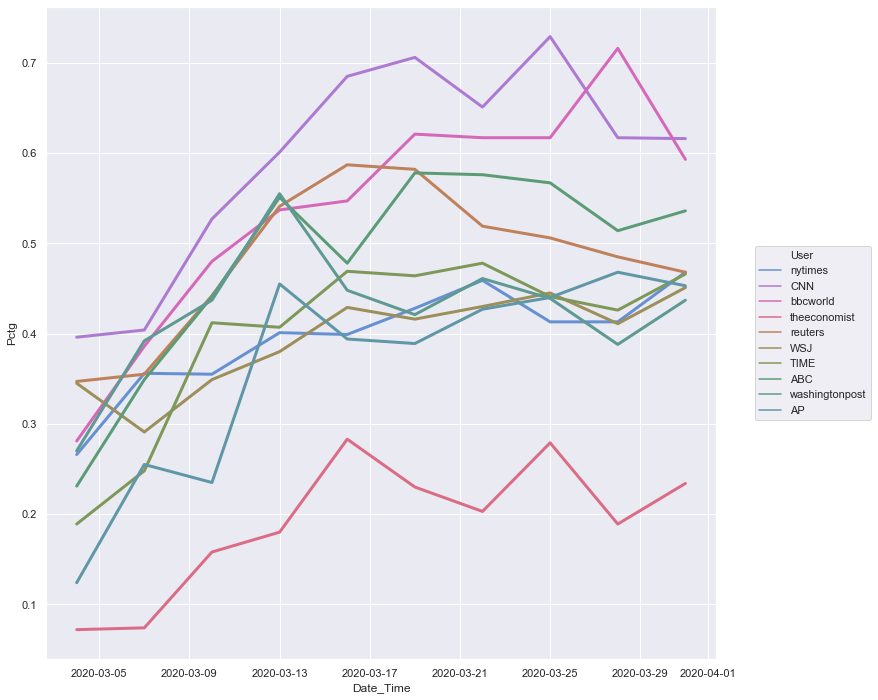

In [132]:
#too messy...
plt.figure(figsize = (12, 12))
lin = sns.lineplot(x = dt2.index, y = dt2['Pctg'], hue = dt2['User'], \
                   lw = 3, palette = PAL, hue_order = ORDER)

lin.legend(loc = 'center left', bbox_to_anchor = (1.05, 0.5), ncol = 1)

In [9]:
for_line = dt2.copy()
for_line['DT'] = for_line.index
for_line['Pctg'] = for_line['Pctg'] * 100
for_line.tail()

,About_COVID,Pctg,User,DT
Date_Time,,,,
2020-03-19,74,38.9,AP,2020-03-19
2020-03-22,61,42.7,AP,2020-03-22
2020-03-25,88,44.0,AP,2020-03-25
2020-03-28,73,46.8,AP,2020-03-28
2020-03-31,53,45.3,AP,2020-03-31


In [10]:
for_line.loc['2020-03-31']['Pctg'].mean()

47.220000000000006

In [11]:
#creating the unweighted average line
alt2 = for_line.copy()
alt2['Type'] = [0] * len(alt2)
om = alt2.groupby('DT').mean()
om['DT'] = om.index
om['Type'] = [1] * 10
om.index.rename('Date_Time', inplace = True)
om

for u in alt2['User'].unique():
    cop = om.copy()
    cop['User'] = [u] * 10
    alt2 = alt2.append(cop)
    
alt2.head()

/Users/emiliolr/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,About_COVID,DT,Pctg,Type,User
Date_Time,,,,,
2020-03-04,93.0,2020-03-04,26.6,0,nytimes
2020-03-07,96.0,2020-03-07,35.6,0,nytimes
2020-03-10,139.0,2020-03-10,35.5,0,nytimes
2020-03-13,136.0,2020-03-13,40.1,0,nytimes
2020-03-16,144.0,2020-03-16,39.9,0,nytimes


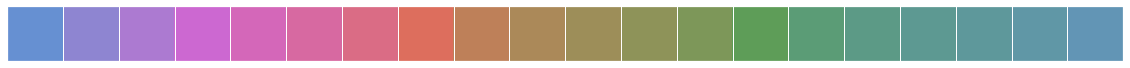

In [12]:
#picking colors for the plot
c = [tuple(p) for p in sns.husl_palette(20, l = 0.6, s = 0.6, h = 0.7)]
sns.palplot(c)
line_palA = sns.color_palette([c[9], c[18]])

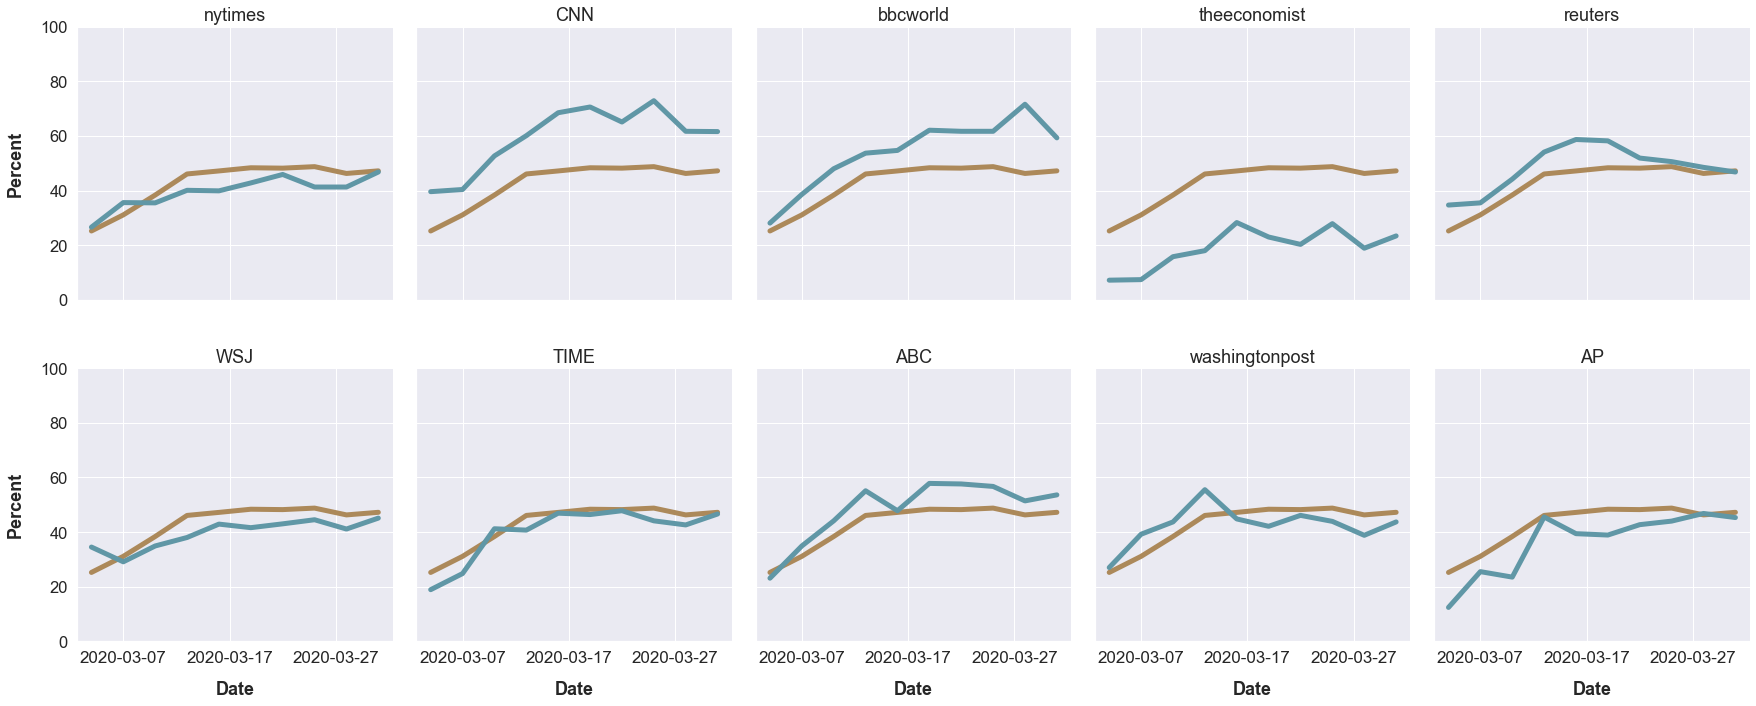

In [14]:
#lineplot of percentage of tweets about COVID using naive categorization
with sns.plotting_context('notebook', font_scale = 1.5):
    e = sns.relplot(data = alt2, x = 'DT', y = 'Pctg', col = 'User', col_wrap = 5, kind = 'line', \
                    lw = 5, palette = line_palA, hue = 'Type', hue_order = [1, 0],\
                    col_order = ORDER, legend = False).set_titles('{col_name}', fontsize = 22).set(ylim = (0, 100),\
                    xticks = ['2020-03-07', '2020-03-17', '2020-03-27'])

    e.fig.subplots_adjust(wspace = 0.075, hspace = 0.25)
    e.set_ylabels('Percent', fontsize = 18, labelpad = 15, **{'fontweight' : 'semibold'})
    e.set_xlabels('Date', fontsize = 18, labelpad = 15, **{'fontweight' : 'semibold'})
    
    #adjusting xticks
    for a in e.axes:
        a.set_xticklabels(['2020-03-07', '2020-03-17', '2020-03-27'], size = 17)

In [15]:
e.savefig('convergence_on_COVID_lineplots.png', dpi = 400)